О наборе данных

Этот набор данных был создан для моделирования реалистичных моделей продаж в индустрии напитков, выделяя такие важные факторы, как региональные предпочтения, сезонные колебания и сегментация клиентов. Он включает транзакции как Business-to-Business (B2B), так и Business-to-Consumer (B2C), что делает его адаптируемым для различных аналитических целей.


- Order_ID Уникальный идентификатор для каждого заказа. Группирует несколько продуктов в одном заказе.
- Customer_ID Уникальный идентификатор для каждого клиента, различающий отдельных покупателей.
- Customer_Type Указывает, является ли клиент B2B (бизнес для бизнеса) или B2C (бизнес для потребителя).
- Product Название приобретенного продукта, например "Coca-Cola" или "Erdinger Weißbier".
- Category Категория продукта, например "Безалкогольные напитки" или "Алкогольные напитки".
- Unit_Price Цена за единицу продукта.
- Quantity Количество единиц, приобретенных для указанного продукта в заказе.
- Discount Скидка, примененная к продукту (например, 0,1 за 10%). Скидки предоставляются только клиентам B2B.
- Total_Price Общая цена продукта после применения скидок.
- Region Регион клиента, например "Bayern" или "Berlin".
- Order_Date Дата размещения заказа.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

Загружаем данные из датасета

In [2]:
# Путь к датасету
file_path = "data/synthetic_beverage_sales_data.csv"

# Считываем данные
df = pd.read_csv(file_path)

df

Order_ID Customer_ID Customer_Type              Product  \
0              ORD1     CUS1496           B2B           Vio Wasser   
1              ORD1     CUS1496           B2B                Evian   
2              ORD1     CUS1496           B2B               Sprite   
3              ORD1     CUS1496           B2B   Rauch Multivitamin   
4              ORD1     CUS1496           B2B         Gerolsteiner   
...             ...         ...           ...                  ...   
8999905  ORD2999999     CUS7080           B2C        Schwip Schwap   
8999906  ORD2999999     CUS7080           B2C       San Pellegrino   
8999907  ORD3000000     CUS6551           B2B             Red Bull   
8999908  ORD3000000     CUS6551           B2B  Passion Fruit Juice   
8999909  ORD3000000     CUS6551           B2B               Vittel   

            Category  Unit_Price  Quantity  Discount  Total_Price  \
0              Water        1.66        53      0.10        79.18   
1              Water        1.56        90      0.10       126.36   
2        Soft Drinks        1.17        73      0.05        81.14   
3             Juices        3.22        59      0.10       170.98   
4              Water        0.87        35      0.10        27.40   
...              ...         ...       ...       ...          ...   
8999905  Soft Drinks        1.27         2      0.00         2.54   
8999906        Water        0.91        15      0.00        13.65   
8999907  Soft Drinks        2.94        64      0.10       169.34   
8999908       Juices        4.04        79      0.10       287.24   
8999909        Water        0.38         9      0.10         3.08   

                    Region  Order_Date  
0        Baden-Württemberg  2023-08-23  
1        Baden-Württemberg  2023-08-23  
2        Baden-Württemberg  2023-08-23  
3        Baden-Württemberg  2023-08-23  
4        Baden-Württemberg  2023-08-23  
...                    ...         ...  
8999905            Sachsen  2023-07-03  
8999906            Sachsen  2023-07-03  
8999907     Sachsen-Anhalt  2022-04-09  
8999908     Sachsen-Anhalt  2022-04-09  
8999909     Sachsen-Anhalt  2022-04-09  

[8999910 rows x 11 columns]

In [3]:
# Проверка общей информации о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999910 entries, 0 to 8999909
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Order_ID       object 
 1   Customer_ID    object 
 2   Customer_Type  object 
 3   Product        object 
 4   Category       object 
 5   Unit_Price     float64
 6   Quantity       int64  
 7   Discount       float64
 8   Total_Price    float64
 9   Region         object 
 10  Order_Date     object 
dtypes: float64(3), int64(1), object(7)
memory usage: 755.3+ MB


Проверим, есть ли пропуски

In [4]:
# Проверка пропущенных значений
print("Пропущенные значения в каждом столбце:")
print(df.isnull().sum())

Пропущенные значения в каждом столбце:
Order_ID         0
Customer_ID      0
Customer_Type    0
Product          0
Category         0
Unit_Price       0
Quantity         0
Discount         0
Total_Price      0
Region           0
Order_Date       0
dtype: int64


Пропусков нет, что прекрасно, т.к. не придется их заполнять

Теперь проведем быстрый анализ датасета

In [5]:
print("Описательная статистика числовых показателей:")
display(df.describe().round(2))

Описательная статистика числовых показателей:


Unit_Price    Quantity    Discount  Total_Price
count  8999910.00  8999910.00  8999910.00   8999910.00
mean         5.82       23.14        0.03       130.74
std         14.70       26.89        0.04       509.69
min          0.32        1.00        0.00         0.30
25%          1.05        6.00        0.00         8.40
50%          1.75       11.00        0.00        21.14
75%          3.21       30.00        0.05        69.49
max        169.53      100.00        0.15     14295.30

Теперь посмотрим, сколько уникальных значений в каждом столбце

In [6]:
# Выводим количество уникальных значений для каждого столбца
print("Количество уникальных значений в каждом столбце:")
for column in df.columns:
    unique_count = df[column].nunique()
    dtype = df[column].dtype
    print(f"{column} ({dtype}): {unique_count} уникальных значений")

Количество уникальных значений в каждом столбце:
Order_ID (object): 3000000 уникальных значений
Customer_ID (object): 10000 уникальных значений
Customer_Type (object): 2 уникальных значений
Product (object): 47 уникальных значений
Category (object): 4 уникальных значений
Unit_Price (float64): 12778 уникальных значений
Quantity (int64): 100 уникальных значений
Discount (float64): 4 уникальных значений
Total_Price (float64): 203842 уникальных значений
Region (object): 16 уникальных значений
Order_Date (object): 1094 уникальных значений


Проведем анализ временных данных

In [7]:
print("\nАнализ временных данных:")
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
print(f"Период покрытия данных: с {df['Order_Date'].min()} по {df['Order_Date'].max()}")
print(f"Всего дней: {(df['Order_Date'].max() - df['Order_Date'].min()).days}")


Анализ временных данных:
Период покрытия данных: с 2021-01-01 00:00:00 по 2023-12-30 00:00:00
Всего дней: 1093


Посмотрим корреляцию у числовых признаков


Корреляция числовых показателей:


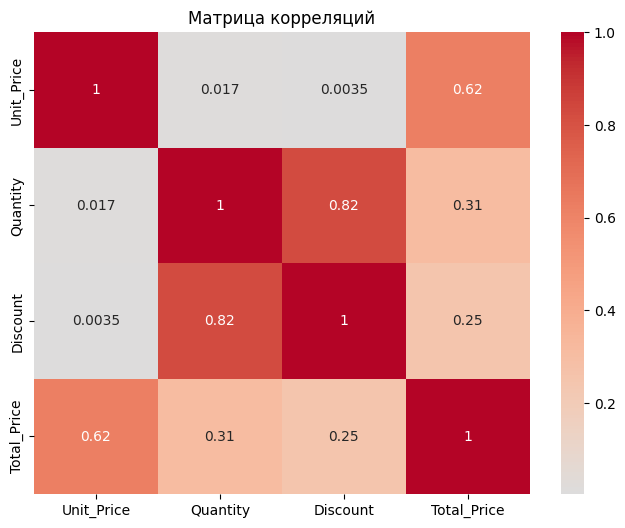

In [8]:
print("\nКорреляция числовых показателей:")
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), 
            annot=True, cmap='coolwarm', center=0)
plt.title("Матрица корреляций")
plt.show()

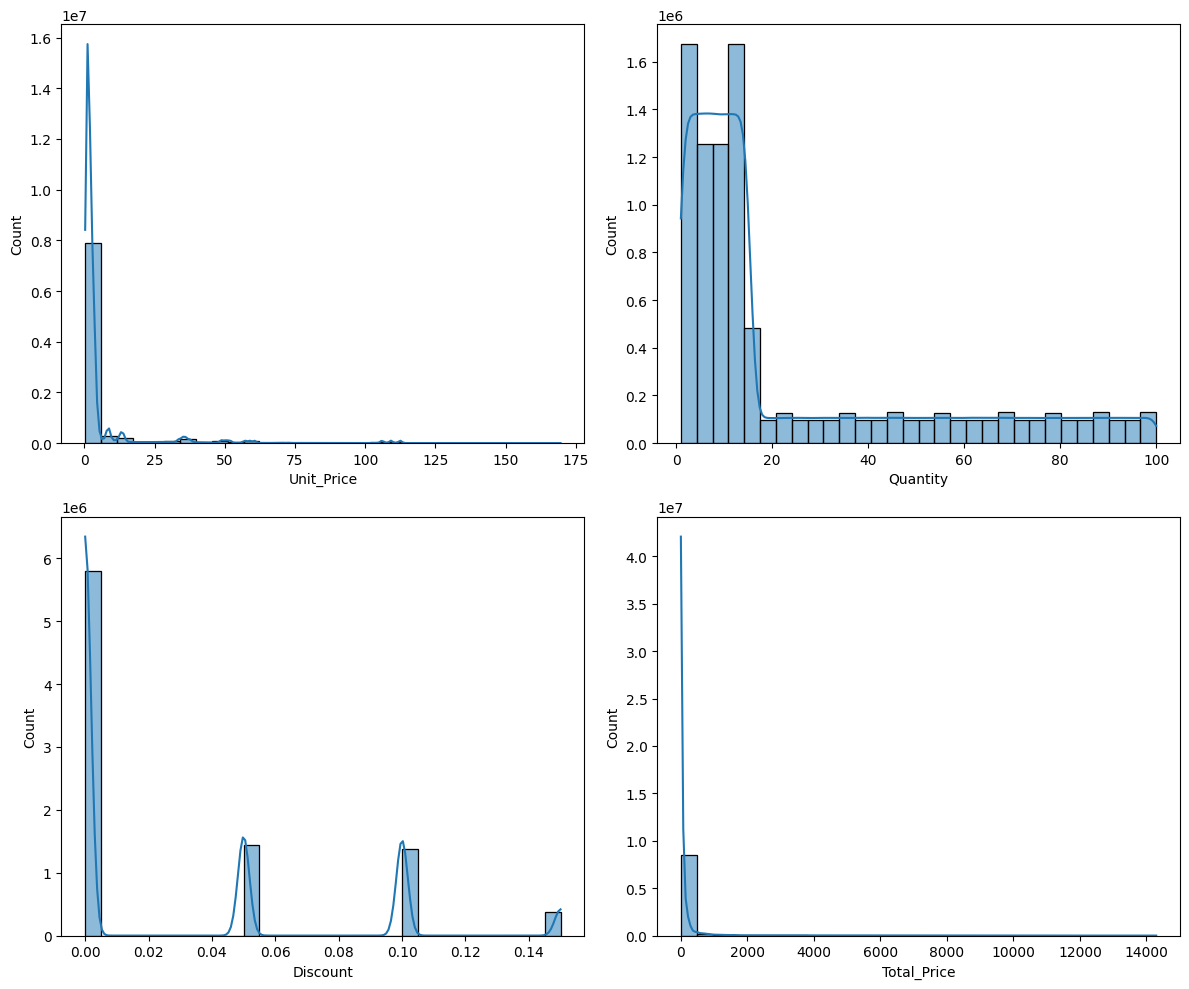

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(df['Unit_Price'], bins=30, kde=True, ax=axes[0, 0])
sns.histplot(df['Quantity'], bins=30, kde=True, ax=axes[0, 1])
sns.histplot(df['Discount'], bins=30, kde=True, ax=axes[1, 0])
sns.histplot(df['Total_Price'], bins=30, kde=True, ax=axes[1, 1])
plt.tight_layout()
plt.show()

Анализ продаж по категориям напитков

In [10]:
print("\nАнализ продаж по категориям:")
category_stats = df.groupby('Category').agg({
    'Total_Price': ['sum', 'mean', 'count'],
    'Quantity': ['sum', 'mean'],
    'Discount': 'mean'
}).sort_values(by=('Total_Price', 'sum'), ascending=False)
display(category_stats.round(2))


Анализ продаж по категориям:


Total_Price                   Quantity        Discount
                              sum    mean    count       sum   mean     mean
Category                                                                    
Alcoholic Beverages  9.117979e+08  404.95  2251625  52109641  23.14     0.03
Juices               1.331678e+08   59.19  2249937  52046874  23.13     0.03
Soft Drinks          8.280254e+07   36.83  2248131  52003710  23.13     0.03
Water                4.891285e+07   21.74  2250217  52080896  23.14     0.03

Интересно, что среднее количество практически не зависит от вида напитков(можно считать погрешностью)

Также можно увидить явную закономерность между типом напитка и средней стоимостью покупки

Посмотрим теперь разницу между B2C и B2B

In [11]:
print("\nАнализ по типам клиентов:")
customer_stats = df.groupby('Customer_Type').agg({
    'Total_Price': ['sum', 'mean', 'count'],
    'Quantity': ['sum', 'mean'],
    'Discount': 'mean',
}).sort_values(by=('Total_Price', 'sum'), ascending=False)
display(customer_stats.round(2))


Анализ по типам клиентов:


Total_Price                    Quantity        Discount
                        sum    mean    count        sum   mean     mean
Customer_Type                                                          
B2B            9.016196e+08  281.36  3204505  161880557  50.52     0.08
B2C            2.750616e+08   47.46  5795405   46360564   8.00     0.00

Видим, что у бизнеса заказы куда больше, чем у простых клиентов. Также бизнес получает оптовые скидки 


Тренды продаж по времени:


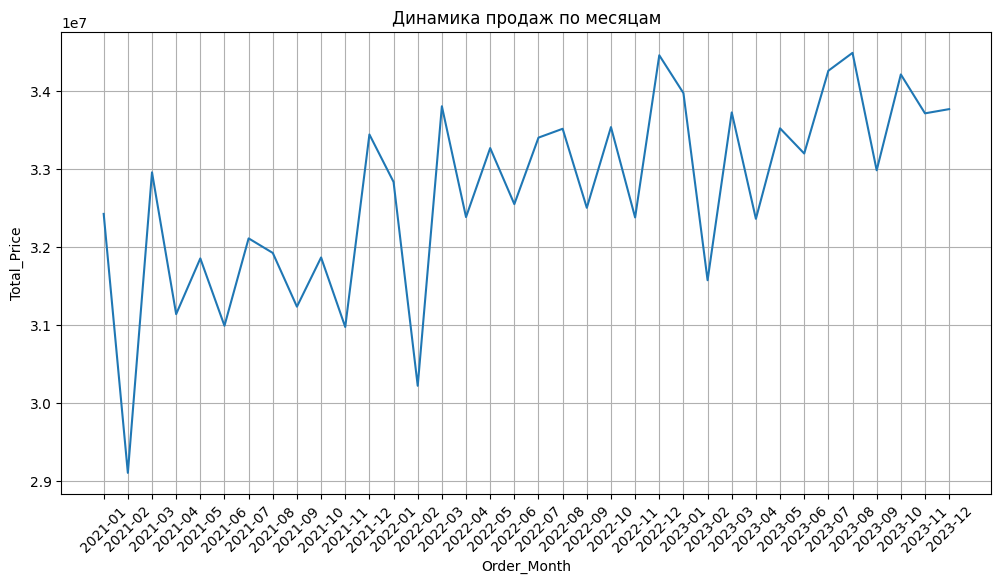

In [12]:
print("\nТренды продаж по времени:")
# Преобразуем дату в datetime и создаем месяц как строку
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Order_Month'] = df['Order_Date'].dt.strftime('%Y-%m')  # Формат "Год-Месяц"

# Группируем по месяцу и суммируем продажи
monthly_sales = df.groupby('Order_Month')['Total_Price'].sum().reset_index()

# Визуализация
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Order_Month', y='Total_Price')
plt.title("Динамика продаж по месяцам")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Видим график с растущим трендом и скачущими значениями. Из них можно явно выделить летнюю и зимнюю сезонность(июль и август практически не отличаются по продажам и являются локальным пиком, также очень много покупок в декабре и январе, скорее всего алкогольных напитков)

/tmp/ipykernel_26677/3340039984.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  category_sales = df.groupby([pd.Grouper(key='Order_Date', freq='M'), 'Category'])['Total_Price'].sum().unstack()
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xli

/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set 

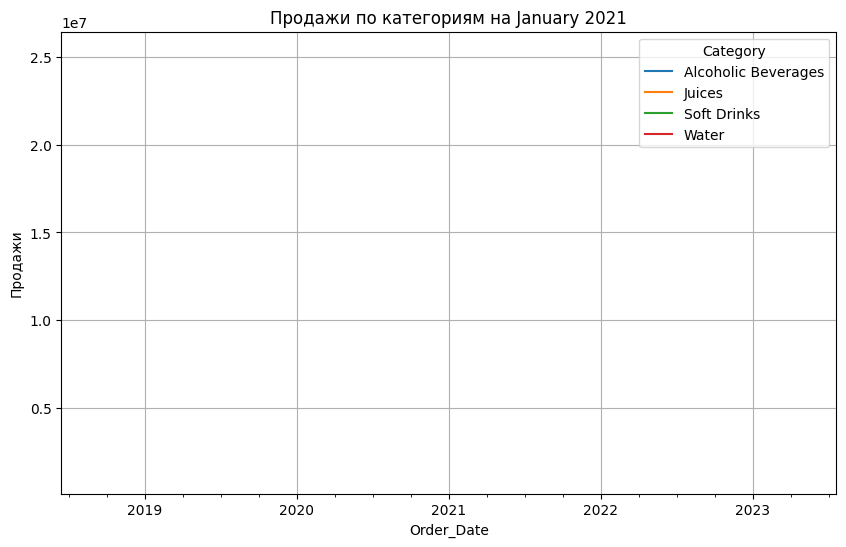

In [13]:
if 'Category' in df.columns:
    # Группируем по месяцу и категории
    category_sales = df.groupby([pd.Grouper(key='Order_Date', freq='M'), 'Category'])['Total_Price'].sum().unstack()

fig, ax = plt.subplots(figsize=(10, 6))
def update(frame):
    ax.clear()
    current_date = category_sales.index[frame]
    data = category_sales.loc[:current_date]
    data.plot(kind='line', ax=ax)
    ax.set_title(f'Продажи по категориям на {current_date.strftime("%B %Y")}')
    ax.set_ylabel('Продажи')
    ax.grid(True)

ani = FuncAnimation(fig, update, frames=len(category_sales.index), interval=500)
HTML(ani.to_jshtml())

Видим значимую сезонность только у алкогольных напитков, так же можно заметить провал продаж всех типов в феврале

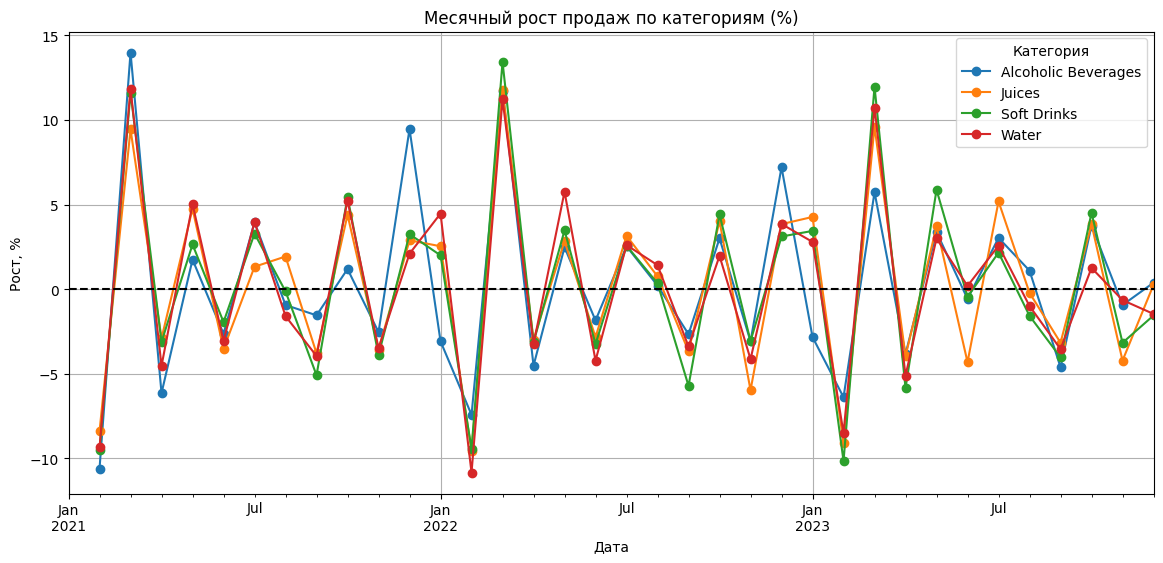

In [14]:
# Вычисляем месячный рост для каждой категории
category_growth = category_sales.pct_change() * 100

plt.figure(figsize=(14, 6))
category_growth.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Месячный рост продаж по категориям (%)')
plt.ylabel('Рост, %')
plt.xlabel('Дата')
plt.grid(True)
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Категория')
plt.show()

Хоть на прошлом графике было не заметно, сезонность у всех напитков общая(кроме алкоголя в декабре)

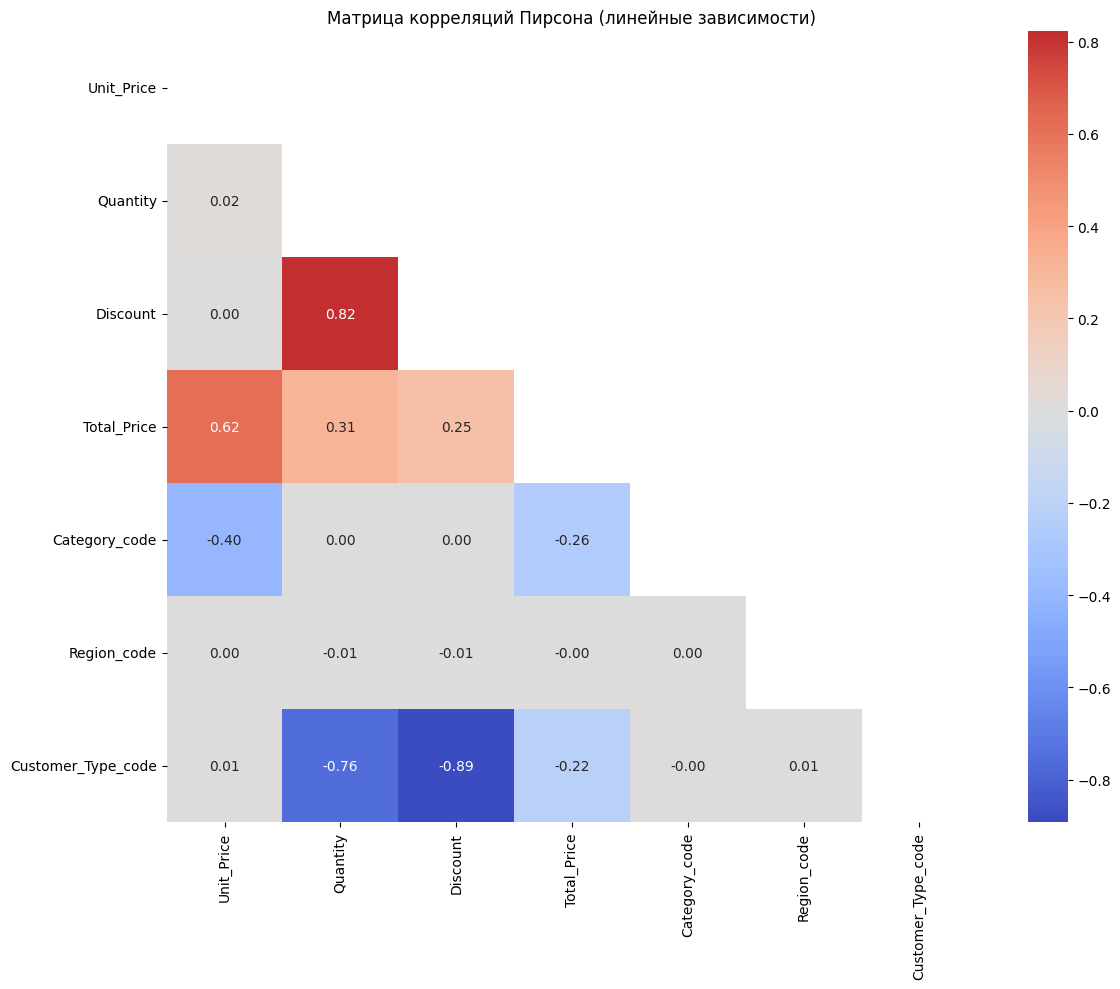

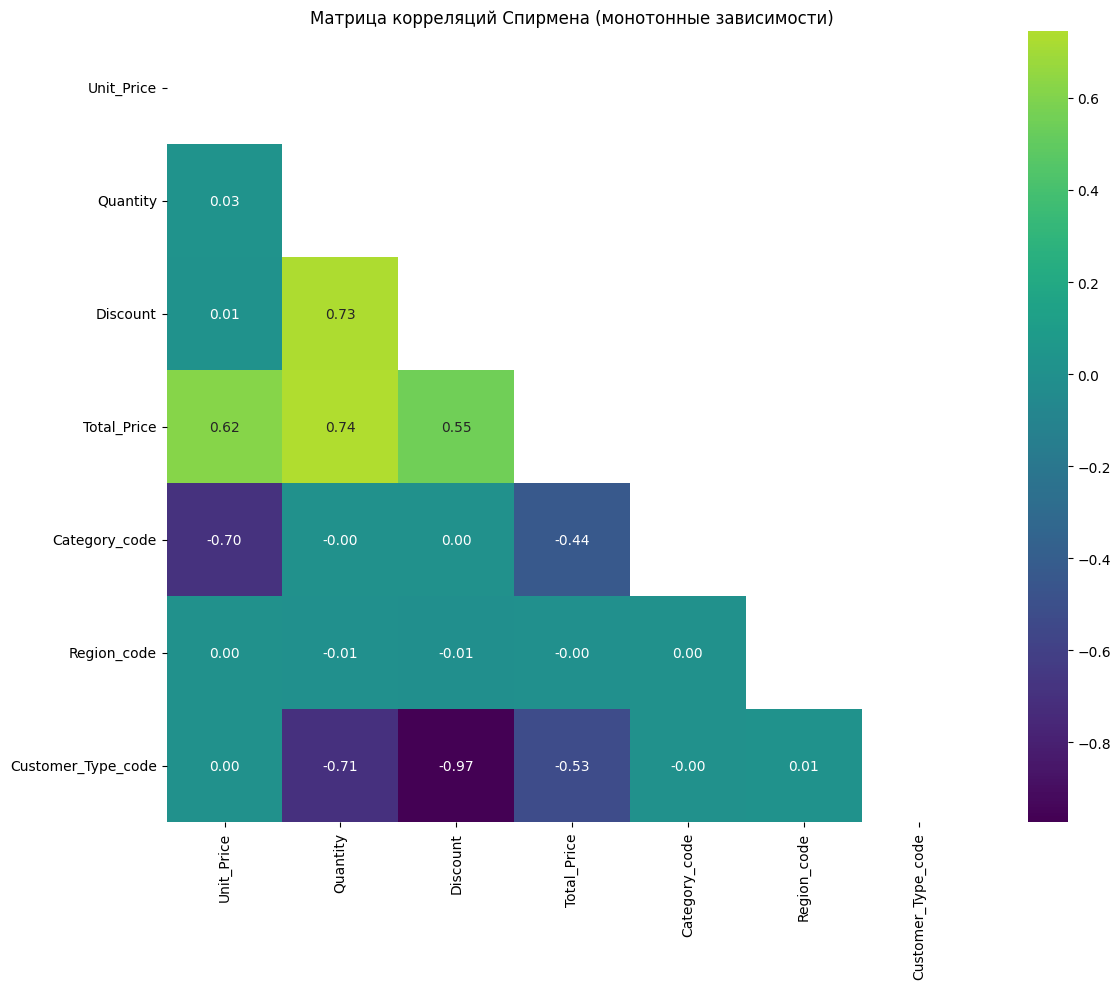

/tmp/ipykernel_26677/3183183959.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)


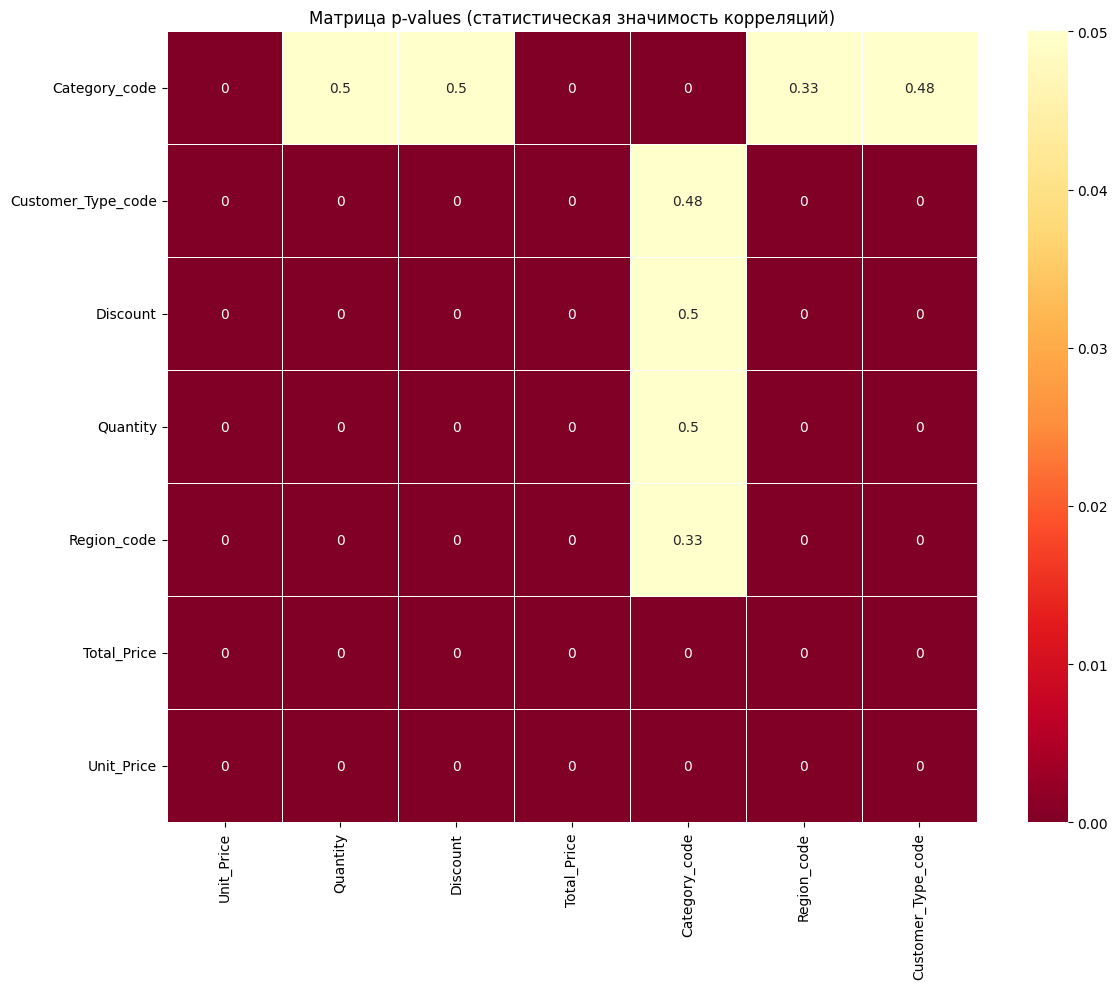

In [15]:
# 1. Подготовка данных
# Создаем копию dataframe для анализа
df_corr = df.copy()

# Преобразуем категориальные данные в числовые (если нужно анализировать их корреляции)
if 'Category' in df.columns:
    df_corr['Category_code'] = df['Category'].astype('category').cat.codes
if 'Region' in df.columns:
    df_corr['Region_code'] = df['Region'].astype('category').cat.codes
if 'Customer_Type' in df.columns:
    df_corr['Customer_Type_code'] = df['Customer_Type'].astype('category').cat.codes

# 2. Матрица корреляций Пирсона (линейные зависимости)
plt.figure(figsize=(12, 10))
numeric_cols = df_corr.select_dtypes(include=[np.number]).columns
pearson_corr = df_corr[numeric_cols].corr()
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f',
            mask=np.triu(np.ones_like(pearson_corr, dtype=bool)))
plt.title('Матрица корреляций Пирсона (линейные зависимости)')
plt.tight_layout()
plt.show()

# 3. Матрица корреляций Спирмена (монотонные зависимости)
plt.figure(figsize=(12, 10))
spearman_corr = df_corr[numeric_cols].corr(method='spearman')
sns.heatmap(spearman_corr, annot=True, cmap='viridis', center=0, fmt='.2f',
            mask=np.triu(np.ones_like(spearman_corr, dtype=bool)))
plt.title('Матрица корреляций Спирмена (монотонные зависимости)')
plt.tight_layout()
plt.show()

# 4. Дополнительный анализ: значимость корреляций
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
    return pvalues

p_values = calculate_pvalues(df_corr[numeric_cols])

plt.figure(figsize=(12, 10))
sns.heatmap(p_values.astype(float), annot=True, cmap='YlOrRd_r',
            vmin=0, vmax=0.05, linewidths=.5)
plt.title('Матрица p-values (статистическая значимость корреляций)')
plt.tight_layout()
plt.show()

Посмотрели корреляции Пирсона и Спирмена для наших признаков, а также значимости этих корреляций через p-value.

Теперь поговорим о том, что мы можем сделать с этими данными:

Прогнозирование спроса

Можно используя временные ряды предсказывать сезонный спрос или же сразу сезонную выручку

Предсказание суммы чека

Можно предсказывать, на какую сумму закупиться клиент (Фичи доступные для моделирования можно регулировать, т.к. с полным набором можно просто посчитать по формуле)

Сегментация покупателей

Можно классифицировать покупателей по определенным признакам, для более индивидуального подхода к каждой из групп

Прогноз повторных покупок

Можно обучить модель для предсказания возвращения покупателей в магазин. Так же если сделать эту модель объясняемой можно будет провести дальнейший анализ

Лучшим вариантом кажется прогнозирование спроса временными моделями, т.к. другие модели реализуются с большими допущениями(например предсказание суммы чека не имеет особого смысла, ведь при всех фичах ее можно просто вычислить, а при меньшем количестве точность уже будет сомнительной: например, как предсказывать сумму чека без количества товаров или их типа. Конечно можно сделать предсказательную систему для старых клиентов, уловив их тенденции, но даже в этом не будет особенного смысла, т.к. работать будет не очень)

Из верхнеуровневых задач, например, можно предсказывать спрос, чтобы закупать нужное количество товара, либо же предсказывать людей, которые готовы были бы сделать покупку, для персональной рекламы. Также можно кластеризовать покупателей для персональных условий(например персональных скидок) по различным признакам. Можно прогнозировать повторные покупки для клиентов и выделить основные признаки для большей вероятности повторных покупок.

Большие заказы можно считать выбросами, но в то же время, они могут объясняться сезоном(например большая закупка алкоголя перед НГ). Посмотрим как будет выглядить график при отсутствии выбросов и решим, будем ли их убирать

/tmp/ipykernel_26677/4055966511.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  category_sales = df1.groupby([pd.Grouper(key='Order_Date', freq='M'), 'Category'])['Total_Price'].sum().unstack()
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xl

/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set 

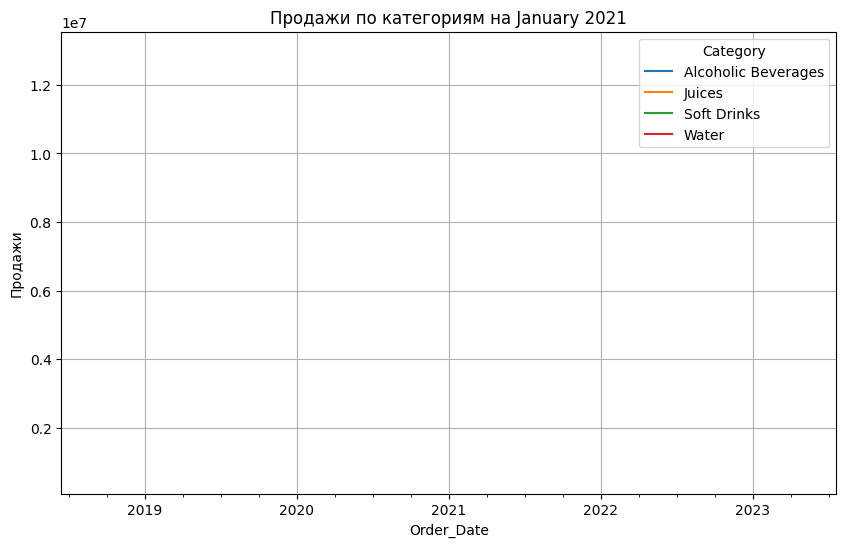

In [16]:
# Удаление выбросов через IQR
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1
df1 = df[~((df['Quantity'] < (Q1 - 1.5 * IQR)) | (df['Quantity'] > (Q3 + 1.5 * IQR)))]

if 'Category' in df1.columns:
    # Группируем по месяцу и категории
    category_sales = df1.groupby([pd.Grouper(key='Order_Date', freq='M'), 'Category'])['Total_Price'].sum().unstack()

fig, ax = plt.subplots(figsize=(10, 6))
def update(frame):
    ax.clear()
    current_date = category_sales.index[frame]
    data = category_sales.loc[:current_date]
    data.plot(kind='line', ax=ax)
    ax.set_title(f'Продажи по категориям на {current_date.strftime("%B %Y")}')
    ax.set_ylabel('Продажи')
    ax.grid(True)

ani = FuncAnimation(fig, update, frames=len(category_sales.index), interval=500)
HTML(ani.to_jshtml())

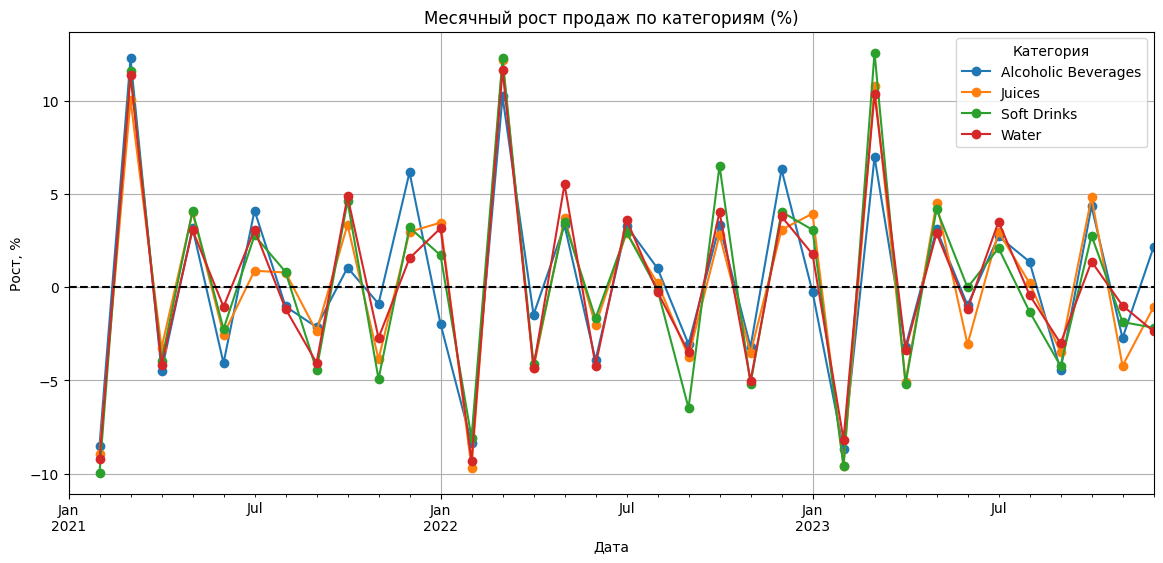

In [17]:
# Вычисляем месячный рост для каждой категории
category_growth = category_sales.pct_change() * 100

plt.figure(figsize=(14, 6))
category_growth.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Месячный рост продаж по категориям (%)')
plt.ylabel('Рост, %')
plt.xlabel('Дата')
plt.grid(True)
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Категория')
plt.show()

Видим, что данные поменялись не сильно, но все же в лучшую сторону, так что будем удалять выбросы

Построим предсказательную модель на временных рядах

Попробуем несколько алгоритмов: линейную регрессию, арима и их вариации, предсказывающие каждый тип товаров отдельно

Из метрик будем использовать MAE, MSE, RMSE и MAPE. Эти метрики будут в достаточной точности отражать качество нашей модели. Можно, конечно, было бы использовать метрики, которые скалирую стоимость ошибки от времени, насколько далеко мы предсказываем(чтобы стоимость ошибок скалировалась с ростом доверительного интервала), но в нашем случае достаточно простой временной ряд, так что можем обойтись стандартными метриками

In [18]:
# Преобразуем дату и агрегируем данные
df1['Order_Date'] = pd.to_datetime(df1['Order_Date'])
daily_sales = df1.groupby('Order_Date')['Total_Price'].sum().reset_index()
daily_sales.set_index('Order_Date', inplace=True)

# Разбиваем на train/test (80/20)
split_date = daily_sales.index[int(len(daily_sales)*0.8)]
train = daily_sales.loc[:split_date]
test = daily_sales.loc[split_date:]

# Функция для оценки моделей
def evaluate_model(y_true, y_pred):
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred)*100:.4f}%")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    plt.figure(figsize=(12,6))
    plt.plot(y_true.index, y_true, label='Фактические значения')
    plt.plot(y_true.index, y_pred, label='Прогноз')
    plt.legend()
    plt.show()


def plot_full_comparison(train, test, predictions, model_name):
    plt.figure(figsize=(14, 7))
    
    # Рисуем тренировочные данные
    plt.plot(train.index, train['Total_Price'], label='Тренировочные данные', color='blue', alpha=0.7)
    
    # Рисуем тестовые данные (фактические значения)
    plt.plot(test.index, test['Total_Price'], label='Фактические значения (тест)', color='green', alpha=0.7)
    
    # Рисуем прогноз
    plt.plot(test.index, predictions, label=f'Прогноз ({model_name})', color='red', linestyle='--')
    
    # Добавляем вертикальную линию для разделения train/test
    split_date = test.index[0]
    plt.axvline(x=split_date, color='gray', linestyle=':', linewidth=2)
    plt.text(split_date, plt.ylim()[1]*0.9, ' Train/Test Split ', 
             backgroundcolor='white', color='gray')
    
    # Настраиваем формат дат
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate()
    
    plt.title(f'Прогнозирование продаж: {model_name}\n(Полный период)')
    plt.ylabel('Сумма продаж')
    plt.xlabel('Дата')
    plt.legend()
    plt.grid(True)
    plt.show()

/tmp/ipykernel_26677/245588611.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Order_Date'] = pd.to_datetime(df1['Order_Date'])


Линейная регрессия с временными признаками


Модель с окном 1:
Коэффициенты: [0.15116589]
Intercept: 475991.71
MAE: 26500.85
MAPE: 4.4138%
RMSE: 33357.03


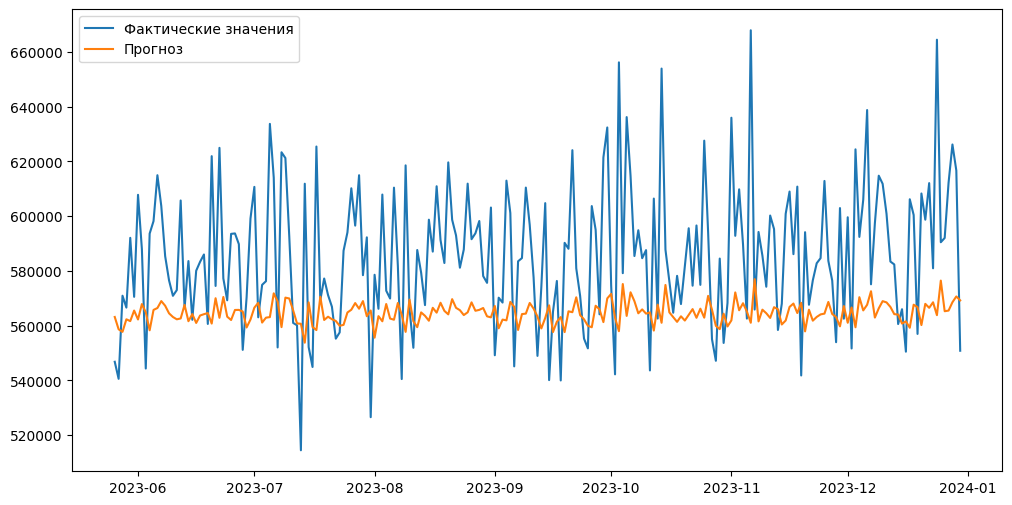

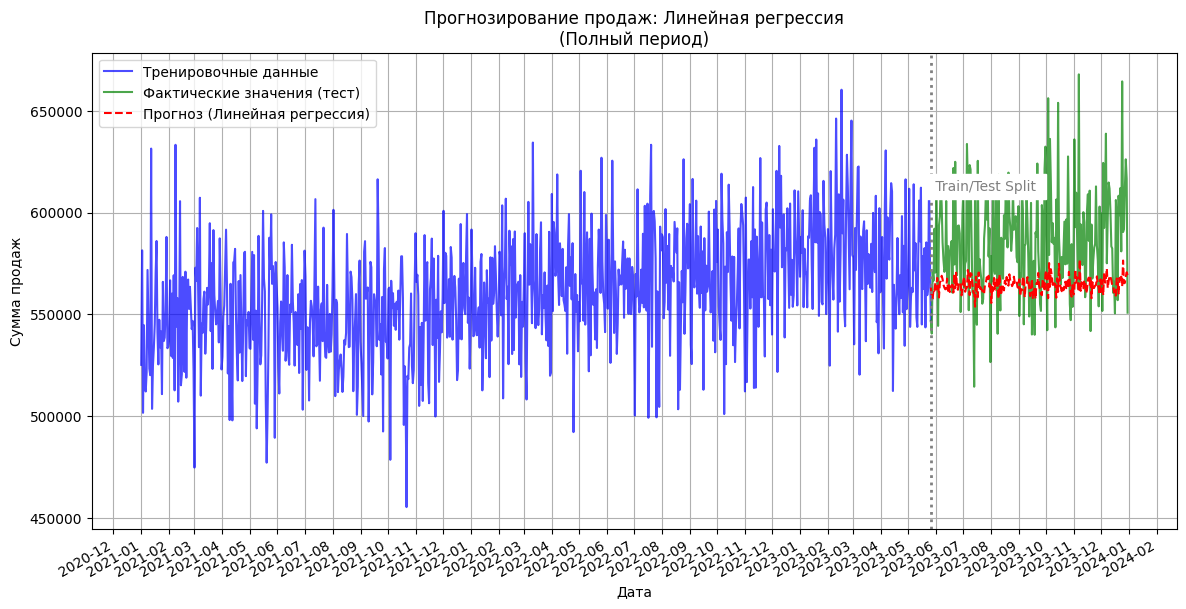


Модель с окном 5:
Коэффициенты: [0.09860238 0.10252395 0.05109174 0.13945304 0.07400064]
Intercept: 299753.28
MAE: 22607.47
MAPE: 3.7865%
RMSE: 29090.14


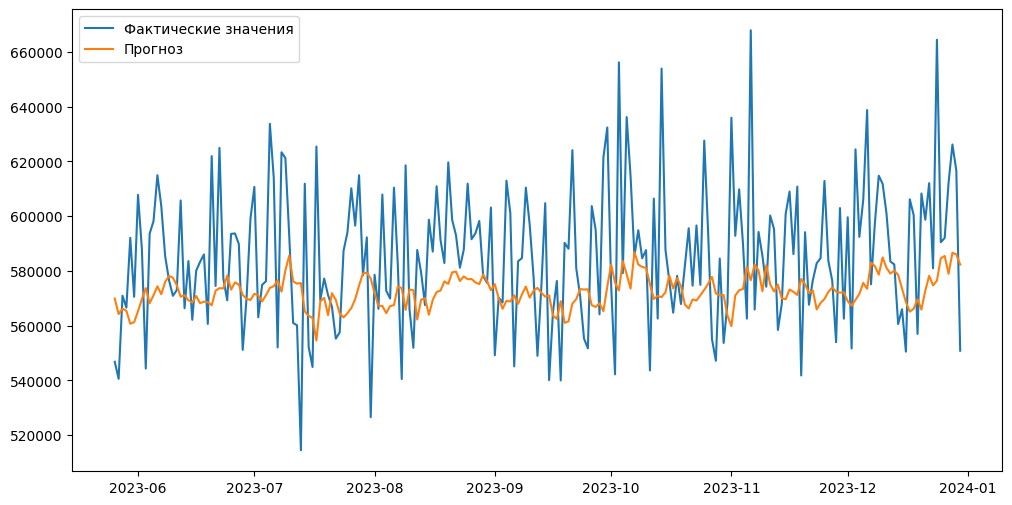

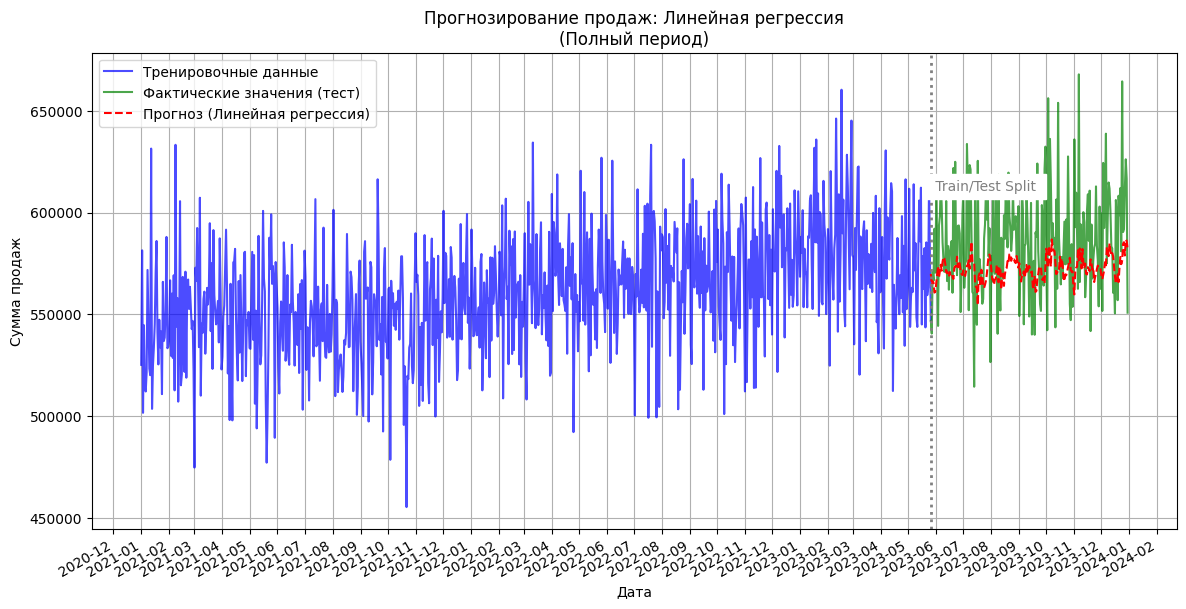


Модель с окном 15:
Коэффициенты: [ 0.02446204  0.02735598 -0.02234591  0.0582063   0.01271203  0.0639733
  0.06785671  0.09551231  0.02106224  0.06511563  0.08805324  0.08662512
  0.07738797  0.05514777  0.0539166 ]
Intercept: 126518.57
MAE: 21354.81
MAPE: 3.6124%
RMSE: 27144.69


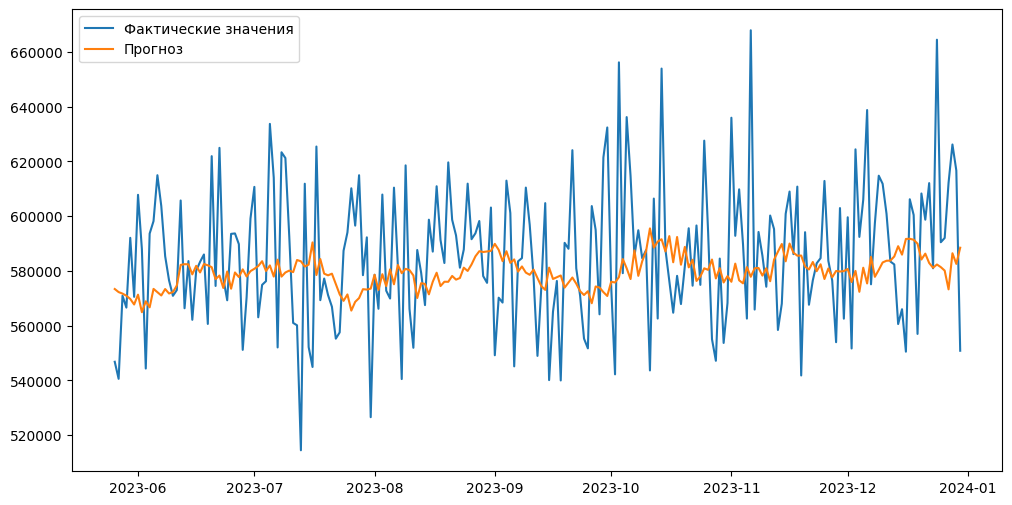

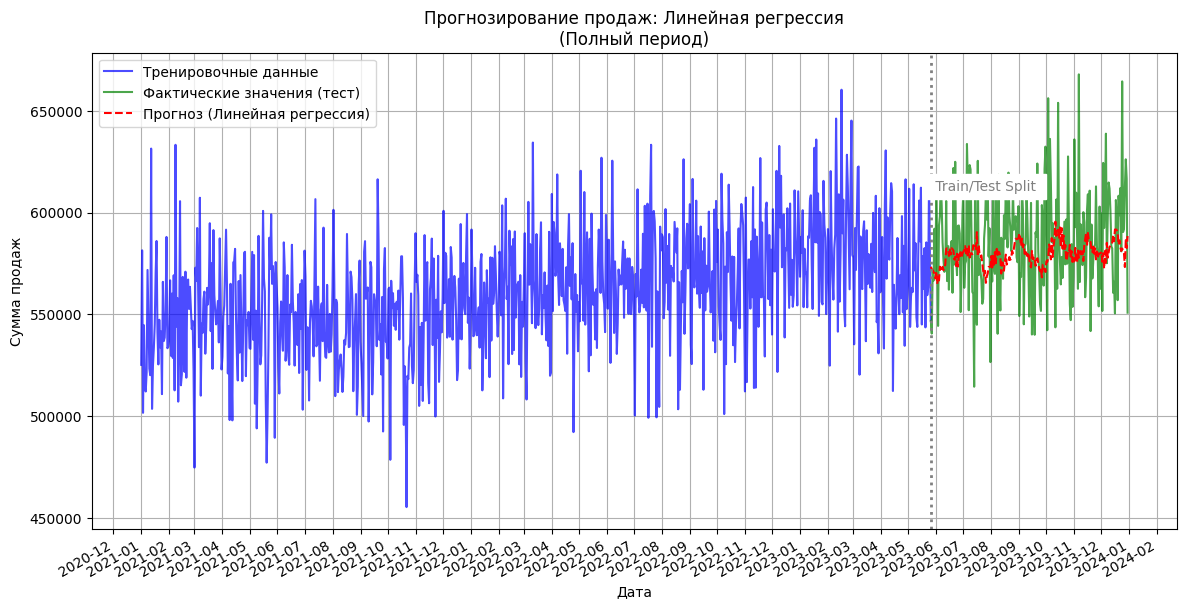


Модель с окном 50:
Коэффициенты: [-0.00655654  0.00046603 -0.05859176  0.006178   -0.0322211   0.0008047
  0.0236348   0.05325682 -0.02525974  0.0021016   0.03425634  0.04549015
  0.03992367  0.02204345  0.01877873  0.05887517  0.03944239  0.00497815
  0.01728576  0.03478944  0.03344616  0.0235279   0.06114242  0.05205889
  0.01721972  0.07976297  0.04449775 -0.0340769  -0.00421791  0.01824685
  0.04276085  0.04576764  0.04184817 -0.02424684  0.01809892  0.05704125
  0.04964043 -0.00356044  0.01726755 -0.03856675  0.02248438  0.05365817
  0.01206533 -0.0279431   0.03662458 -0.01409391 -0.01839757  0.01332009
  0.04326336  0.01854635]
Intercept: 47466.52
MAE: 21207.09
MAPE: 3.6017%
RMSE: 26503.57


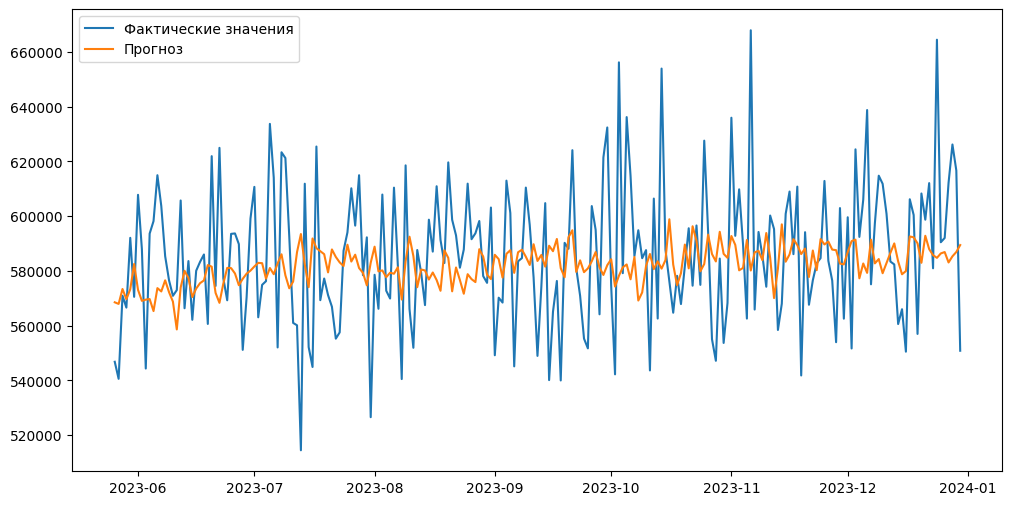

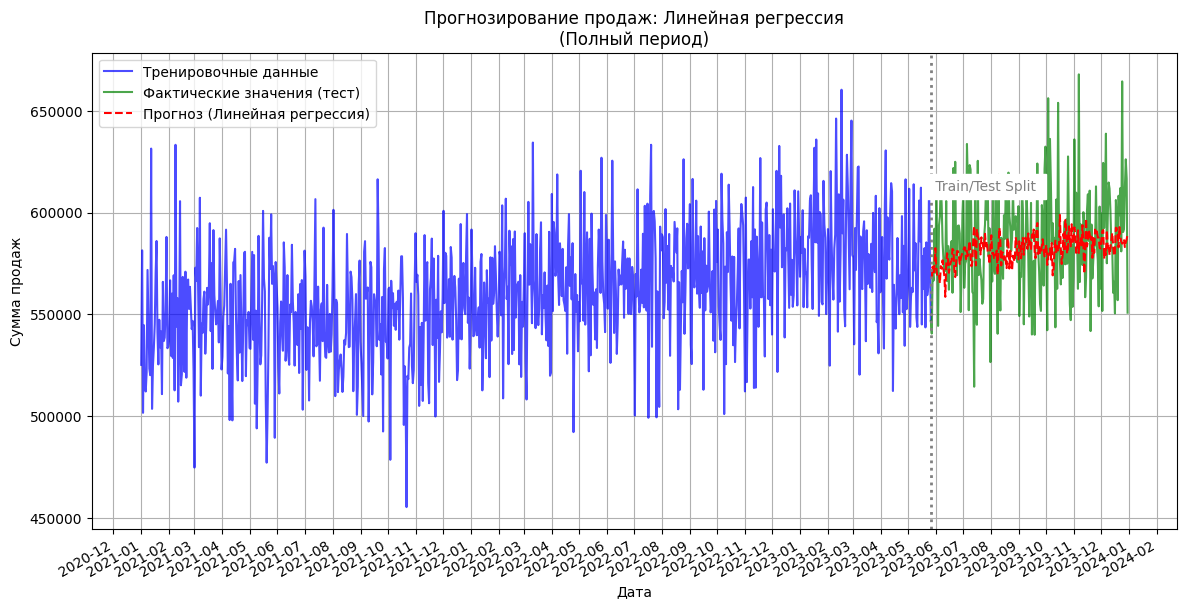

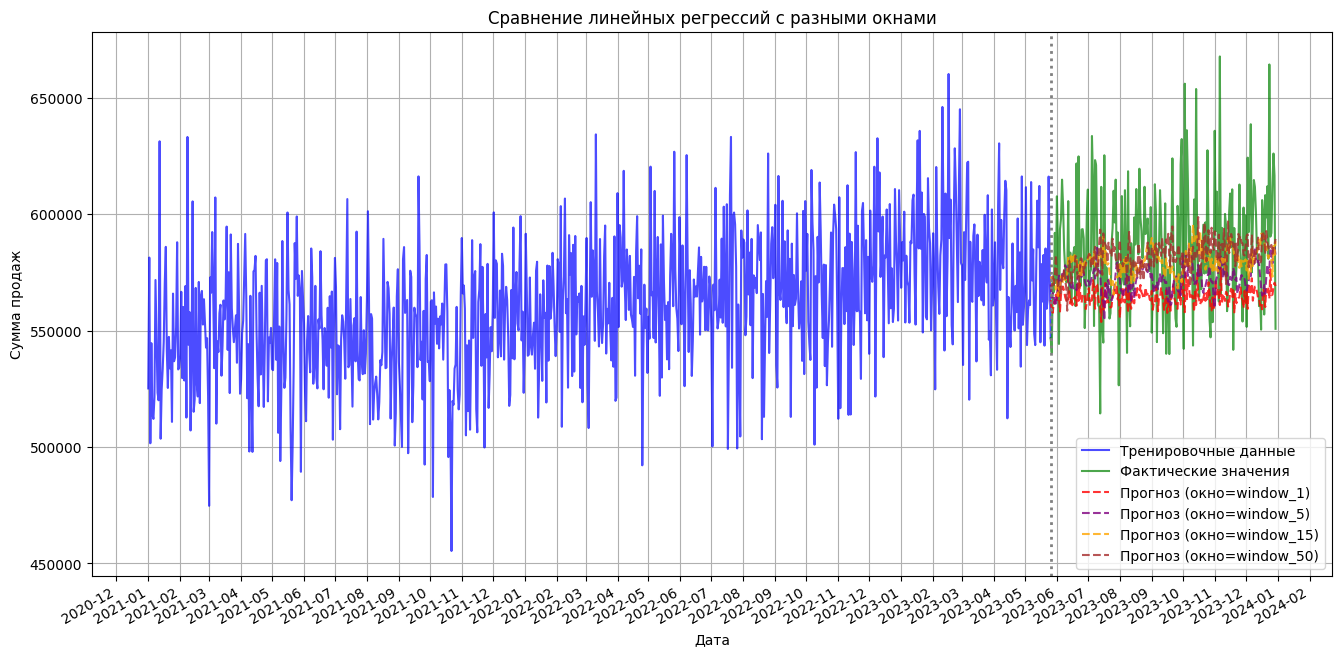


Сравнение метрик:


Window           MAE   MAPE, %          RMSE
3     50  21207.094722  3.601704  26503.574683
2     15  21354.806527  3.612371  27144.690726
1      5  22607.467607  3.786544  29090.135452
0      1  26500.853739  4.413795  33357.030095

In [19]:
# Создаем функцию для подготовки данных с разным окном
def create_lagged_features(data, window_size):
    df = pd.DataFrame(data.copy())
    for i in range(1, window_size+1):
        df[f'lag_{i}'] = df['Total_Price'].shift(i)
    df.dropna(inplace=True)
    return df

# Функция для визуализации результатов
def plot_lr_comparison(train, test, predictions_dict):
    plt.figure(figsize=(16, 8))
    
    # Рисуем тренировочные данные
    plt.plot(train.index, train['Total_Price'], label='Тренировочные данные', color='blue', alpha=0.7)
    
    # Рисуем тестовые данные
    plt.plot(test.index, test['Total_Price'], label='Фактические значения', color='green', alpha=0.7)
    
    # Рисуем прогнозы для каждого окна
    colors = ['red', 'purple', 'orange', 'brown']
    for i, (window, pred) in enumerate(predictions_dict.items()):
        plt.plot(test.index, pred, label=f'Прогноз (окно={window})', 
                linestyle='--', color=colors[i], alpha=0.8)
    
    # Линия разделения train/test
    split_date = test.index[0]
    plt.axvline(x=split_date, color='gray', linestyle=':', linewidth=2)
    
    # Настройки графика
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate()
    
    plt.title('Сравнение линейных регрессий с разными окнами')
    plt.ylabel('Сумма продаж')
    plt.xlabel('Дата')
    plt.legend()
    plt.grid(True)
    plt.show()

# Параметры окон
window_sizes = [1, 5, 15, 50]
predictions = {}

for window in window_sizes:
    # Создаем данные с лаговыми признаками
    lagged_data = create_lagged_features(daily_sales, window)
    
    # Разделяем на train/test
    train_lagged = lagged_data.loc[:split_date]
    test_lagged = lagged_data.loc[split_date:]
    
    # Разделяем на X и y
    X_train = train_lagged.drop('Total_Price', axis=1)
    y_train = train_lagged['Total_Price']
    X_test = test_lagged.drop('Total_Price', axis=1)
    y_test = test_lagged['Total_Price']
    
    # Обучаем модель
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # Делаем прогноз
    pred = lr.predict(X_test)
    predictions[f'window_{window}'] = pred
    
    # Выводим метрики
    print(f'\nМодель с окном {window}:')
    print(f"Коэффициенты: {lr.coef_}")
    print(f"Intercept: {lr.intercept_:.2f}")
    evaluate_model(y_test, pred)
    plot_full_comparison(train, test, pred, 'Линейная регрессия')

# Визуализируем все модели
plot_lr_comparison(train, test, predictions)

# Дополнительно: таблица сравнения метрик
metrics = []
for window, pred in predictions.items():
    mae = mean_absolute_error(y_test, pred)
    mape = mean_absolute_percentage_error(y_test, pred)*100
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    metrics.append({'Window': window.replace('window_', ''), 'MAE': mae, 'MAPE, %': mape, 'RMSE': rmse})

metrics_df = pd.DataFrame(metrics)
print("\nСравнение метрик:")
display(metrics_df.sort_values('MAE'))

Получили достаточно неплохие для такой простой реализации, а также посмотрели зависимость точности от размера плавающего окна

Теперь расмотрим модель SARIMAX, попробуем применить ее(не будем производить тонкую настройку, хотя она необходима для такого мощного инструмента)

/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


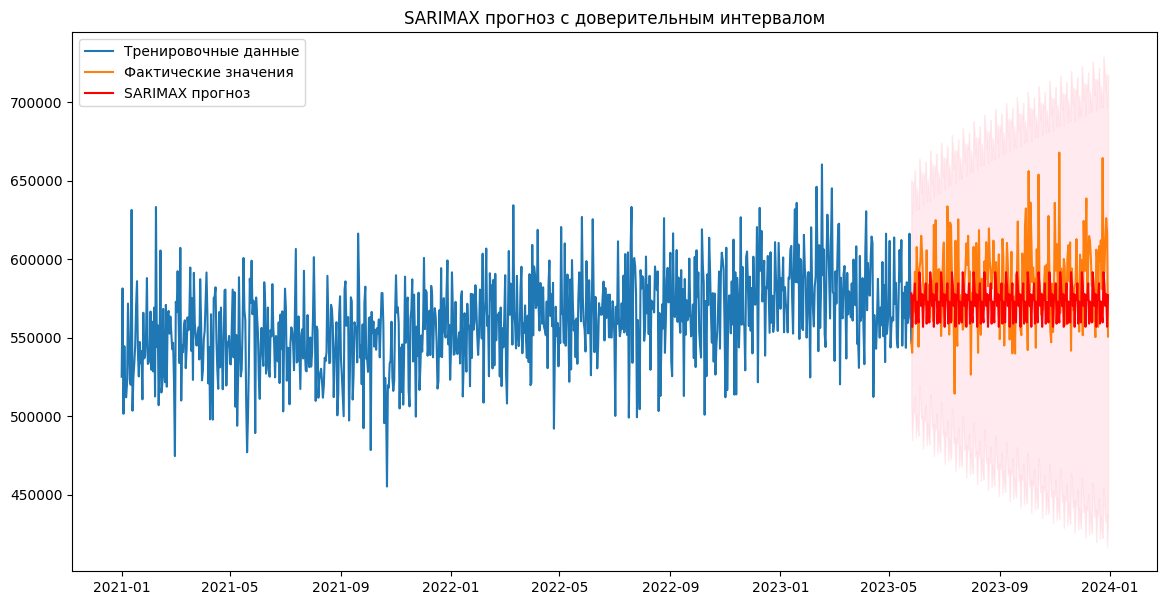

MAE: 23819.72
MAPE: 3.9991%
RMSE: 30839.76


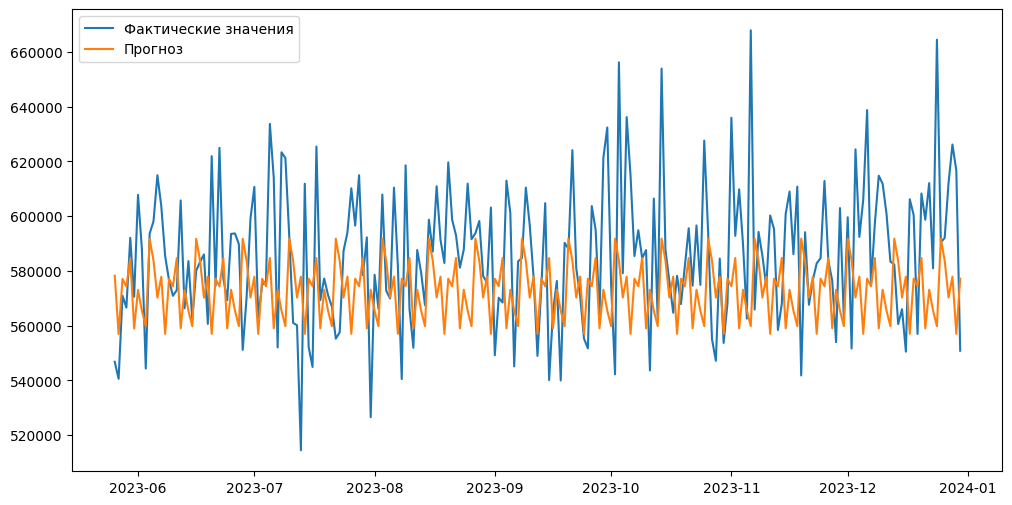

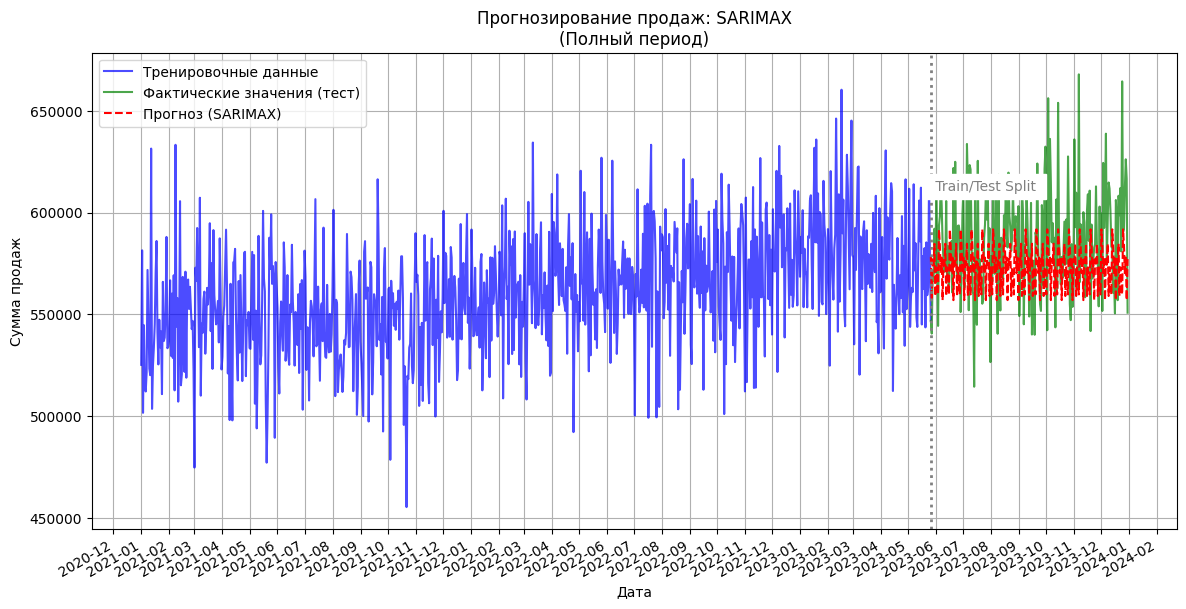

In [20]:
# Оптимальные параметры из auto_arima (пример значений)
order = (1, 0, 2)
seasonal_order = (0, 1, 1, 12)

model = SARIMAX(train,
               order=order,
               seasonal_order=seasonal_order,
               enforce_stationarity=False,
               enforce_invertibility=False)

results = model.fit(disp=False)

# Прогноз на длину тестового набора
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Визуализация
plt.figure(figsize=(14,7))
plt.plot(train.index, train['Total_Price'], label='Тренировочные данные')
plt.plot(test.index, test['Total_Price'], label='Фактические значения')
plt.plot(test.index, forecast_mean, label='SARIMAX прогноз', color='red')
plt.fill_between(test.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1],
                color='pink', alpha=0.3)
plt.legend()
plt.title('SARIMAX прогноз с доверительным интервалом')
plt.show()
evaluate_model(y_test, forecast_mean)
plot_full_comparison(train, test, forecast_mean, 'SARIMAX')

Видим, что без чтательной настройки модели, SARIMAX немного, но все же проигрывает линейной регрессии

Теперь попробуем применить SARIMAX на каждую категорию товаров в отдельности, а затем сложим полученные предсказания


Прогнозирование для категории: Water


/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Прогнозирование для категории: Soft Drinks


/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Прогнозирование для категории: Juices


/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Прогнозирование для категории: Alcoholic Beverages


/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/taifun/Documents/ml/spbu_ml_2025/done_homeworks/hw1/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


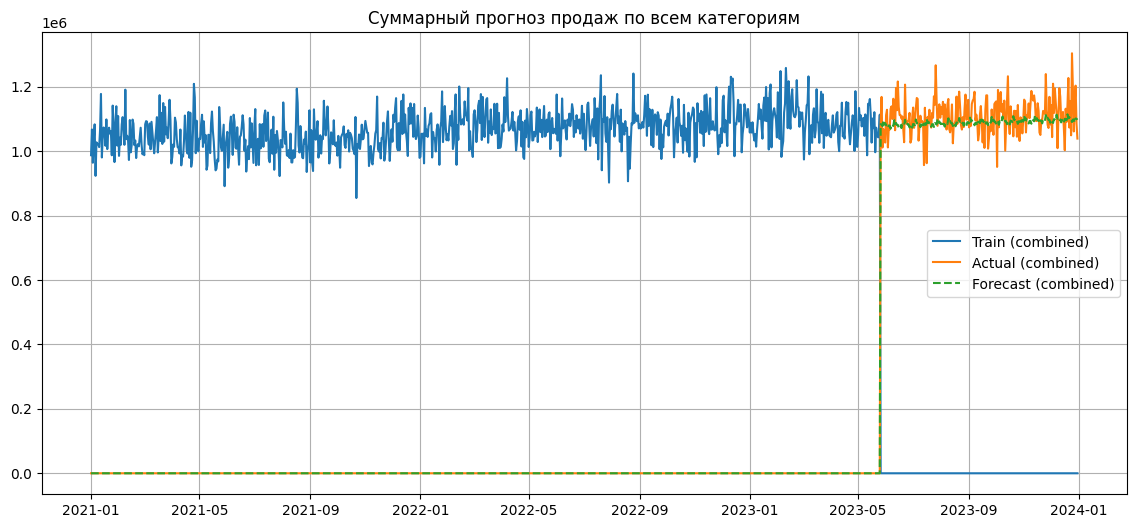


Оценка комбинированного прогноза:
MAE: 8944.67
MAPE: 0.80%


In [21]:
# 1. Подготовка данных
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
categories = df['Category'].unique()

# 2. Функция для ручного подбора ARIMA параметров
def manual_arima_forecast(train, test, order=(1,1,1), seasonal_order=(1,1,1,12)):
    model = ARIMA(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

# 3. Прогнозирование для каждой категории
category_results = {}
for category in categories:
    print(f"\nПрогнозирование для категории: {category}")
    
    # Подготовка данных
    category_data = df[df['Category'] == category]
    daily_sales = category_data.groupby('Order_Date')['Total_Price'].sum()
    
    # Разделение на train/test (80/20)
    split_idx = int(len(daily_sales) * 0.8)
    train = daily_sales.iloc[:split_idx]
    test = daily_sales.iloc[split_idx:]
    
    # Подбираем параметры вручную (можно экспериментировать)
    if len(train) > 30:  # Для длинных рядов используем сезонность
        forecast = manual_arima_forecast(train, test, order=(1,1,1), seasonal_order=(1,1,1,12))
    else:  # Для коротких рядов простую ARIMA
        forecast = manual_arima_forecast(train, test, order=(1,1,1))
    
    category_results[category] = {
        'train': train,
        'test': test,
        'forecast': forecast
    }

# 4. Суммирование прогнозов (аналогично предыдущему решению)
def combine_forecasts(category_results):
    # Инициализация
    all_dates = pd.date_range(
        start=min([min(res['train'].index) for res in category_results.values()]),
        end=max([max(res['test'].index) for res in category_results.values()]),
        freq='D'
    )
    
    combined = pd.DataFrame(index=all_dates)
    
    # Суммируем прогнозы по всем категориям
    for category, res in category_results.items():
        combined[f'{category}_train'] = res['train']
        combined[f'{category}_test'] = res['test']
        combined[f'{category}_forecast'] = res['forecast']
    
    # Заполняем пропуски нулями (если для какой-то даты нет продаж)
    combined.fillna(0, inplace=True)
    
    # Суммируем
    combined['total_train'] = combined[[c for c in combined.columns if '_train' in c]].sum(axis=1)
    combined['total_test'] = combined[[c for c in combined.columns if '_test' in c]].sum(axis=1)
    combined['total_forecast'] = combined[[c for c in combined.columns if '_forecast' in c]].sum(axis=1)
    
    return combined

combined = combine_forecasts(category_results)

# 5. Визуализация итогового прогноза
plt.figure(figsize=(14, 6))
plt.plot(combined.index, combined['total_train'], label='Train (combined)')
plt.plot(combined.index, combined['total_test'], label='Actual (combined)')
plt.plot(combined.index, combined['total_forecast'], label='Forecast (combined)', linestyle='--')
plt.title('Суммарный прогноз продаж по всем категориям')
plt.legend()
plt.grid()
plt.show()

# 6. Оценка качества
def evaluate_forecast(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    mape = mean_absolute_percentage_error(actual, forecast) * 100
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")

print("\nОценка комбинированного прогноза:")
evaluate_forecast(combined['total_test'], combined['total_forecast'])

Как видим, получили прекрасный результат, такая точность является прекрасной для временных рядов

Все наши модели дают достаточно стационарные предсказания, т.к. данные сами по себе достаточно шумные, но благодаря тому, что алгоритмы хорошо угадывают тренд и работают с сезонностью и периодичностью, удалось значить понизить наши метрики и улучшить результаты. А благодаря достаточно высокой точности, данные модели можно использовать в реальных бизнес-задачах


Например, можно вести планирование бюджета, опираясь на ожидаемый доход, тем самым пустить больше денег в дело, чтобы зарабатывать больше. Либо же можно построить аналогичную модель, предсказывающую не доход, а количество купленного товара, тем самым регулируя свои закупки и оптимизируя хранение на складе. Во всех этих вариантах идеальными бизнес-метриками будут уже перечисленные нами стандартные метрики. Их можно слегка кастомизировать, для оптимизации моделей(например, штрафовать сильнее за преуменьшение, чем за преувеличение - лучше будут запасы на складе, чем терять клиента из-за отсутствия товара). Так же из более сложных бизнес метрик можно посчитать выгоду, которую приносит эта оптимизация(за счет сокращения размера склада, или большего вложения капитала в дело)